<a href="https://colab.research.google.com/github/chetan-parthiban/Conceptors/blob/master/MNIST_Debiasing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports/Clones

In [1]:
!git clone https://github.com/chetan-parthiban/fakeai.git
!pip install wget

rm: cannot remove 'fakeai': No such file or directory
Cloning into 'fakeai'...
remote: Enumerating objects: 88, done.
remote: Counting objects: 100% (88/88), done.
remote: Compressing objects: 100% (65/65), done.
remote: Total 88 (delta 26), reused 71 (delta 13), pack-reused 0
Unpacking objects: 100% (88/88), done.
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [0]:
import fakeai.data as d
from fakeai.data.utils import *
from pathlib import Path
from functools import partial
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

## Get MNIST

In [3]:
d.download_data('https://pjreddie.com/media/files/mnist_train.csv','mnist_train.csv', ext = '')
d.download_data('https://pjreddie.com/media/files/mnist_test.csv','mnist_test.csv', ext = '')

PosixPath('mnist_test.csv')

In [0]:
sd = d.SplitData.from_csv('mnist_train.csv', 'mnist_test.csv', tfms = d.Reshape(28))
ld = sd.label_by_idx(0, proc_x = [], proc_y = [])
db = ld.to_databunch(10000)

torch.Size([60000, 1, 28, 28])
tensor([7., 4.])


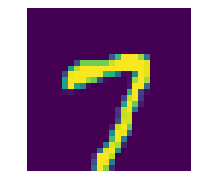

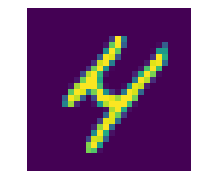

In [14]:
n = 2
xb, yb = db.get_sample()
print(xb.shape)
xb = xb[:,0,:,:]
d.show_images(xb, n, perm = False)
print(yb[0:n])

## Create Cheater

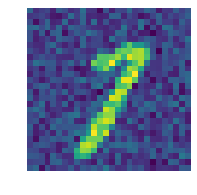

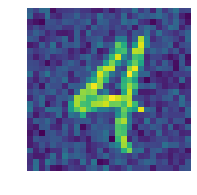

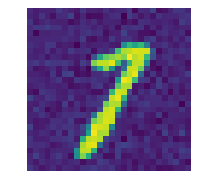

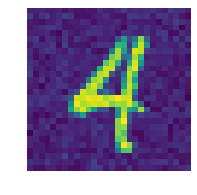

In [167]:
class Cheater():
    
    def __init__(self, const = 200):
        self.rot = torch.randint(10,(784,784)).float()
        self.rot, _ = torch.qr(self.rot) 
        self.inv = torch.pinverse(self.rot)
        self.const = const
        
        self.easy = torch.randint(10,(10,784)).float()
        
    def cheat(self, input, labels):
        input = input.reshape(-1,784)
        transformed = input @ self.rot
        transformed[:,0] = transformed[:,0] + (labels-5) * self.const
        return (transformed @ self.inv).reshape(-1,28,28)
    
    def _cheat(self, input, labels):
        input = input.reshape(-1,784)
        transformed = input @ self.rot
        transformed[:,0] = transformed[:,0] + (labels-5) * self.const
        return transformed @ self.inv
    
    def debias(self, input, alpha = 0.01):
        input = input.reshape(-1,784)
        transformed = input @ self.rot
        transformed[:,:10] = transformed[:,:10] * alpha
        return (transformed @ self.inv).reshape(-1,28,28)
    
    def _debias(self, input, alpha = 0.01):
        transformed = input @ self.rot
        transformed[:,:10] = transformed[:,:10] * alpha
        return transformed
    
    def _easy(self, input, labels):
        input = input.reshape(-1, 784)
        labels = labels.type(torch.LongTensor)
        input = input + self.easy[labels,:] * self.const
        return input
    
    def easy_(self, input, labels):
        return self._easy(input, labels).reshape(-1,28,28)
    
    def _fancy(self, input, labels):
        input = input.reshape(-1,784)
        transformed = input @ self.rot
        labels = labels.type(torch.LongTensor)
        idx = torch.arange(transformed.shape[0])
        transformed[idx,labels] = transformed[idx,labels] + self.const 
        return transformed @ self.inv
        
    def fancy(self, input, labels):
        return self._fancy(input,labels).reshape(-1,28,28)
    
    def _transform(self, input):
        return input @ self.rot
    
    def cuda(self):
        self.rot = self.rot.cuda()
        self.inv = self.inv.cuda()
        self.easy = self.easy.cuda()
        
    def cpu(self):
        self.rot = self.rot.cpu()
        self.inv = self.inv.cpu()
        self.easy = self.easy.cpu()
        

xb, yb = db.get_sample()
cheater = Cheater(1000)
xb = cheater.fancy(xb, yb)
show_images(xb, 2, perm = False)
xb = cheater.debias(xb, alpha = 0.1)
show_images(xb, 2, perm = False)

# Create and train baseline model

In [0]:
#Linear Model
class Model(nn.Module):
    
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(784, 10)
        
    def forward(self, input):
        
        return self.fc1(input)

In [27]:
cheat = False
easy = False
fancy = False

debias = False

bias = 100
reduction = 1

cheater = Cheater(bias)
cheater.cuda()
model = Model()
model.cuda()
loss_func = nn.CrossEntropyLoss()
model

Model(
  (fc1): Linear(in_features=784, out_features=10, bias=True)
)

In [0]:
lr = 0.001
opt = optim.Adam(model.parameters(), lr = lr)

In [30]:
model.train()
for i in range(20):
    
    running_acc = 0
    running_count = 0
    
    for xb,yb in db.train_dl:
        xb,yb = xb.cuda(),yb.cuda()
        yb = yb.type(torch.LongTensor).cuda()
        if cheat: 
            xb = cheater._cheat(xb, yb)
        elif easy:
            xb = cheater._easy(xb, yb)
        elif fancy:
            xb = cheater._fancy(xb, yb)
            if debias: xb = cheater._debias(xb, alpha = reduction)
        else:
            xb = xb.reshape(-1, 784)
        pred = model(xb)
        loss = loss_func(pred, yb)
        loss.backward()
        opt.step()
        opt.zero_grad()
        correct = (torch.argmax(pred, 1) == yb).sum().float()/pred.shape[0]
        running_acc += float(correct.detach())
        running_count += 1
    print(f'Epoch {i} Accuracy: {running_acc/running_count}')

Epoch 0 Accuracy: 0.885049968957901
Epoch 1 Accuracy: 0.8871166507403055
Epoch 2 Accuracy: 0.8887666463851929
Epoch 3 Accuracy: 0.8899499674638113
Epoch 4 Accuracy: 0.8921166261037191
Epoch 5 Accuracy: 0.8923166394233704
Epoch 6 Accuracy: 0.8927666346232096
Epoch 7 Accuracy: 0.8936166365941366
Epoch 8 Accuracy: 0.8949666519959768
Epoch 9 Accuracy: 0.8946499824523926


In [31]:
model.eval()

running_acc = 0
running_count = 0

for xb,yb in db.valid_dl:
    
    xb,yb = xb.cuda(),yb.cuda()
    
    yb = yb.type(torch.LongTensor).cuda()
    
    if cheat: 
        xb = cheater._cheat(xb, yb)
    elif easy:
        xb = cheater._easy(xb, yb)
    elif fancy:
        xb = cheater._fancy(xb, yb)
        if debias: xb = cheater._debias(xb, alpha = reduction)
    else:
        xb = xb.reshape(-1, 784)
        
    pred = model(xb)
    correct = (torch.argmax(pred, 1) == yb).sum().float()/pred.shape[0]
    running_acc += float(correct.detach())
    running_count += 1
    
print(f'Test Accuracy: {running_acc/running_count}')

Test Accuracy: 0.8896999955177307


# Train Biased Model

In [168]:
cheat = False
easy = False
fancy = True

debias = False

bias = 100
reduction = 1

cheater = Cheater(bias)
cheater.cuda()
model = Model()
model.cuda()
loss_func = nn.CrossEntropyLoss()
model

Model(
  (fc1): Linear(in_features=784, out_features=10, bias=True)
)

In [0]:
lr = 0.001
opt = optim.Adam(model.parameters(), lr = lr)

In [170]:
model.train()
for i in range(20):
    
    running_acc = 0
    running_count = 0
    
    for xb,yb in db.train_dl:
        xb,yb = xb.cuda(),yb.cuda()
        yb = yb.type(torch.LongTensor).cuda()
        if cheat: 
            xb = cheater._cheat(xb, yb)
        elif easy:
            xb = cheater._easy(xb, yb)
        elif fancy:
            xb = cheater._fancy(xb, yb)
            if debias: xb = cheater._debias(xb, alpha = reduction)
        else:
            xb = xb.reshape(-1, 784)
        pred = model(xb)
        loss = loss_func(pred, yb)
        loss.backward()
        opt.step()
        opt.zero_grad()
        correct = (torch.argmax(pred, 1) == yb).sum().float()/pred.shape[0]
        running_acc += float(correct.detach())
        running_count += 1
    print(f'Epoch {i} Accuracy: {running_acc/running_count}')

Epoch 0 Accuracy: 0.22178332755963007
Epoch 1 Accuracy: 0.6209666530291239
Epoch 2 Accuracy: 0.7958333094914755
Epoch 3 Accuracy: 0.8694999714692434
Epoch 4 Accuracy: 0.9066666464010874
Epoch 5 Accuracy: 0.927866647640864
Epoch 6 Accuracy: 0.9401666422684988
Epoch 7 Accuracy: 0.9492333233356476
Epoch 8 Accuracy: 0.9561333258946737
Epoch 9 Accuracy: 0.9613833030064901
Epoch 10 Accuracy: 0.9661499758561453
Epoch 11 Accuracy: 0.9696166416009268
Epoch 12 Accuracy: 0.9728666444619497
Epoch 13 Accuracy: 0.9752833147843679
Epoch 14 Accuracy: 0.9776166478792826
Epoch 15 Accuracy: 0.9796666502952576
Epoch 16 Accuracy: 0.9814499815305074
Epoch 17 Accuracy: 0.9829833010832468
Epoch 18 Accuracy: 0.9843499859174093
Epoch 19 Accuracy: 0.9856666425863901


In [174]:
model.eval()

running_acc = 0
running_count = 0

for xb,yb in db.valid_dl:
    
    xb,yb = xb.cuda(),yb.cuda()
    
    yb = yb.type(torch.LongTensor).cuda()
    
    if cheat: 
        xb = cheater._cheat(xb, yb)
    elif easy:
        xb = cheater._easy(xb, yb)
    elif fancy:
        xb = cheater._fancy(xb, yb)
        if debias: xb = cheater._debias(xb, alpha = reduction)
    else:
        xb = xb.reshape(-1, 784)
        
    pred = model(xb)
    correct = (torch.argmax(pred, 1) == yb).sum().float()/pred.shape[0]
    running_acc += float(correct.detach())
    running_count += 1
    
print(f'Test Accuracy: {running_acc/running_count}')

Test Accuracy: 0.9821999669075012


# Train Debiased Model (No Rotation)

In [175]:
cheat = False
easy = False
fancy = True

debias = True

bias = 1000
reduction = 0.01

cheater = Cheater(bias)
cheater.cuda()
model = Model()
model.cuda()
loss_func = nn.CrossEntropyLoss()
model

Model(
  (fc1): Linear(in_features=784, out_features=10, bias=True)
)

In [0]:
lr = 0.01
opt = optim.Adam(model.parameters(), lr = lr, weight_decay = 0, eps = 1e-3)

In [188]:
model.train()
for i in range(20):
    
    running_acc = 0
    running_count = 0
    
    for xb,yb in db.train_dl:
        xb,yb = xb.cuda(),yb.cuda()
        yb = yb.type(torch.LongTensor).cuda()
        if cheat: 
            xb = cheater._cheat(xb, yb)
        elif easy:
            xb = cheater._easy(xb, yb)
        elif fancy:
            xb = cheater._fancy(xb, yb)
            if debias: xb = cheater._debias(xb, alpha = reduction)
        else:
            xb = xb.reshape(-1, 784)
        pred = model(xb)
        loss = loss_func(pred, yb)
        loss.backward()
        opt.step()
        opt.zero_grad()
        correct = (torch.argmax(pred, 1) == yb).sum().float()/pred.shape[0]
        running_acc += float(correct.detach())
        running_count += 1
    print(f'Epoch {i} Accuracy: {running_acc/running_count}')

Epoch 0 Accuracy: 0.9683166444301605
Epoch 1 Accuracy: 0.9725833137830099
Epoch 2 Accuracy: 0.9760999878247579
Epoch 3 Accuracy: 0.9788999855518341
Epoch 4 Accuracy: 0.9807166357835134
Epoch 5 Accuracy: 0.9824666281541189
Epoch 6 Accuracy: 0.9828499853610992
Epoch 7 Accuracy: 0.9852833151817322
Epoch 8 Accuracy: 0.9865999817848206
Epoch 9 Accuracy: 0.9872166315714518
Epoch 10 Accuracy: 0.988566646973292
Epoch 11 Accuracy: 0.9901333153247833
Epoch 12 Accuracy: 0.9904999732971191
Epoch 13 Accuracy: 0.991299976905187
Epoch 14 Accuracy: 0.992283304532369
Epoch 15 Accuracy: 0.9929499725500742
Epoch 16 Accuracy: 0.9934999744097391
Epoch 17 Accuracy: 0.9942666490872701
Epoch 18 Accuracy: 0.9951166411240896
Epoch 19 Accuracy: 0.9954333007335663


In [189]:
print(model.fc1.weight.abs().sum(dim = 0)[0:30])

tensor([ 1.8839,  3.2656, 11.2788, 10.6952,  9.3570, 12.6006,  6.2490,  6.6837,
        12.6168,  9.5060,  0.1728,  0.1700,  0.1642,  0.1874,  0.1031,  0.1169,
         0.2563,  0.1450,  0.2237,  0.1381,  0.1872,  0.2098,  0.2118,  0.1631,
         0.2282,  0.1275,  0.2063,  0.3329,  0.1597,  0.2202], device='cuda:0',
       grad_fn=<SliceBackward>)


In [190]:
model.eval()

running_acc = 0
running_count = 0

for xb,yb in db.valid_dl:
    
    xb,yb = xb.cuda(),yb.cuda()
    
    yb = yb.type(torch.LongTensor).cuda()
    
    if cheat: 
        xb = cheater._cheat(xb, yb)
    elif easy:
        xb = cheater._easy(xb, yb)
    elif fancy:
        xb = cheater._fancy(xb, yb)
        if debias: xb = cheater._debias(xb, alpha = reduction)
    else:
        xb = xb.reshape(-1, 784)
        
    pred = model(xb)
    correct = (torch.argmax(pred, 1) == yb).sum().float()/pred.shape[0]
    running_acc += float(correct.detach())
    running_count += 1
    
print(f'Test Accuracy: {running_acc/running_count}')

Test Accuracy: 0.9756999611854553


# Train Debiased Model (Rotated)

In [0]:
class Cheater():
    
    def __init__(self, const = 200):
        self.rot = torch.randint(10,(784,784)).float()
        self.rot, _ = torch.qr(self.rot) 
        self.inv = torch.pinverse(self.rot)
        self.const = const
        
        self.easy = torch.randint(10,(10,784)).float()
        
    def _debias(self, input, alpha = 0.01):
        transformed = input @ self.rot
        transformed[:,:10] = transformed[:,:10] * alpha
        return transformed @ self.inv
    
    
    def _fancy(self, input, labels):
        input = input.reshape(-1,784)
        transformed = input @ self.rot
        labels = labels.type(torch.LongTensor)
        idx = torch.arange(transformed.shape[0])
        transformed[idx,labels] = transformed[idx,labels] + self.const 
        return transformed @ self.inv
        
    
    def cuda(self):
        self.rot = self.rot.cuda()
        self.inv = self.inv.cuda()
        self.easy = self.easy.cuda()
        
    def cpu(self):
        self.rot = self.rot.cpu()
        self.inv = self.inv.cpu()
        self.easy = self.easy.cpu()
        

In [154]:
cheat = False
easy = False
fancy = True

debias = True

bias = 1000
reduction = 0.01

cheater = Cheater(bias)
cheater.cuda()
model = Model()
model.cuda()
loss_func = nn.CrossEntropyLoss()
model

Model(
  (fc1): Linear(in_features=784, out_features=10, bias=True)
)

In [0]:
lr = 0.01
opt = optim.Adam(model.parameters(), lr = lr, weight_decay = 0)

In [160]:
model.train()
for i in range(20):
    
    running_acc = 0
    running_count = 0
    
    for xb,yb in db.train_dl:
        xb,yb = xb.cuda(),yb.cuda()
        yb = yb.type(torch.LongTensor).cuda()
        if cheat: 
            xb = cheater._cheat(xb, yb)
        elif easy:
            xb = cheater._easy(xb, yb)
        elif fancy:
            xb = cheater._fancy(xb, yb)
            if debias: xb = cheater._debias(xb, alpha = reduction)
        else:
            xb = xb.reshape(-1, 784)
        pred = model(xb)
        loss = loss_func(pred, yb)
        loss.backward()
        opt.step()
        opt.zero_grad()
        correct = (torch.argmax(pred, 1) == yb).sum().float()/pred.shape[0]
        running_acc += float(correct.detach())
        running_count += 1
    print(f'Epoch {i} Accuracy: {running_acc/running_count}')

Epoch 0 Accuracy: 0.9336666564146677
Epoch 1 Accuracy: 0.9282333155473074
Epoch 2 Accuracy: 0.9324999849001566
Epoch 3 Accuracy: 0.9280999799569448
Epoch 4 Accuracy: 0.9310499727725983
Epoch 5 Accuracy: 0.9320166409015656
Epoch 6 Accuracy: 0.9355833133061727
Epoch 7 Accuracy: 0.936466634273529
Epoch 8 Accuracy: 0.8262166380882263
Epoch 9 Accuracy: 0.6253333191076914
Epoch 10 Accuracy: 0.7890999813874563
Epoch 11 Accuracy: 0.8591833015282949
Epoch 12 Accuracy: 0.8838333288828532
Epoch 13 Accuracy: 0.9029166400432587
Epoch 14 Accuracy: 0.9076666434605917
Epoch 15 Accuracy: 0.9135833084583282
Epoch 16 Accuracy: 0.9189499815305074
Epoch 17 Accuracy: 0.9209999839464823
Epoch 18 Accuracy: 0.9240666528542837
Epoch 19 Accuracy: 0.9249166448911031


In [166]:
model.eval()

running_acc = 0
running_count = 0

for xb,yb in db.valid_dl:
    
    xb,yb = xb.cuda(),yb.cuda()
    
    yb = yb.type(torch.LongTensor).cuda()
    
    if cheat: 
        xb = cheater._cheat(xb, yb)
    elif easy:
        xb = cheater._easy(xb, yb)
    elif fancy:
        xb = cheater._fancy(xb, yb)
        if debias: xb = cheater._debias(xb, alpha = reduction)
    else:
        xb = xb.reshape(-1, 784)
        
    pred = model(xb)
    correct = (torch.argmax(pred, 1) == yb).sum().float()/pred.shape[0]
    running_acc += float(correct.detach())
    running_count += 1
    
print(f'Test Accuracy: {running_acc/running_count}')

Test Accuracy: 0.9230999946594238
